In [122]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [123]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training KKC with *minimal_SARIMAX*

In [124]:
import sys
sys.path.append('../')

In [125]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [126]:
train_set = pd.read_csv('6Hsampled_data_set/KKC/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/KKC/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/KKC/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [127]:
order = (2, 1, 0)
seasonal_order = (0, 1, 1, 1461)

exog_order = {}
exog_order['Temp'] = (1, 0, 1)
exog_order['WindSpeed'] = (1, 1, 0)
exog_order['WindDirSin'] = (2, 0, 0)
exog_order['WindDirCos'] = (2, 0, 0)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 1, 0, 1461)
exog_seasonal_order['WindSpeed'] = (0, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (1, 0, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 0, 0, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [128]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [129]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.9995, lr_decay_iter=0.75,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:24<00:00, 16.58it/s]


ITER#0  RMSE:10.856174905488237


100%|██████████| 4383/4383 [04:29<00:00, 16.24it/s]


ITER#0  RMSE:16.264513269830868


100%|██████████| 4383/4383 [04:20<00:00, 16.80it/s]


ITER#0  RMSE:7.028602573835336


100%|██████████| 4383/4383 [04:31<00:00, 16.16it/s]

ITER#0  RMSE:7.035170967362694


#### Khonkaen

In [137]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([1e-6, 0, 0, 0, 0]), lr_decay=0.9995, lr_decay_iter=0.75,
                                  step=12, n_iter=1, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [15:02<00:00,  4.85it/s]

ITER#0  RMSE:15.805997735474405


In [138]:
model.params

{'p': array([0.33395068, 0.32109541]),
 'pX': array([0.19590212, 0.13086323, 0.05559458, 0.05387061]),
 'd': array([0.02918068]),
 'q': array([0.]),
 'P': array([0.]),
 'D': array([0.28142147]),
 'Q': array([0.01447714]),
 'c': 0.058676541816036445}

In [133]:
with open('../model_save/model_cnx.model',"wb") as f:
    pickle.dump(model, f)

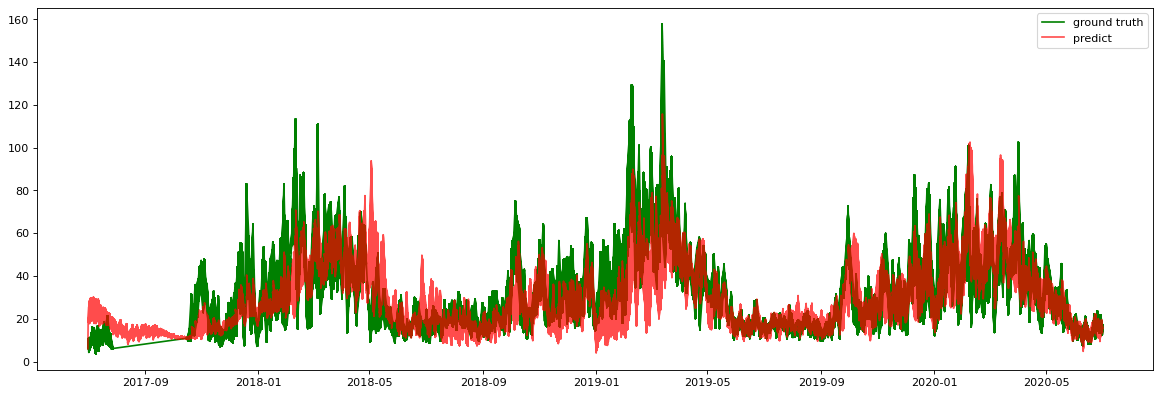

In [139]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [143]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([1e-6, 1e-6, 1e-6, 1e-6, 1e-6]), lr_decay=0.9995,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [08:38<00:00,  5.36it/s]

ITER#0  RMSE:13.86867932687439


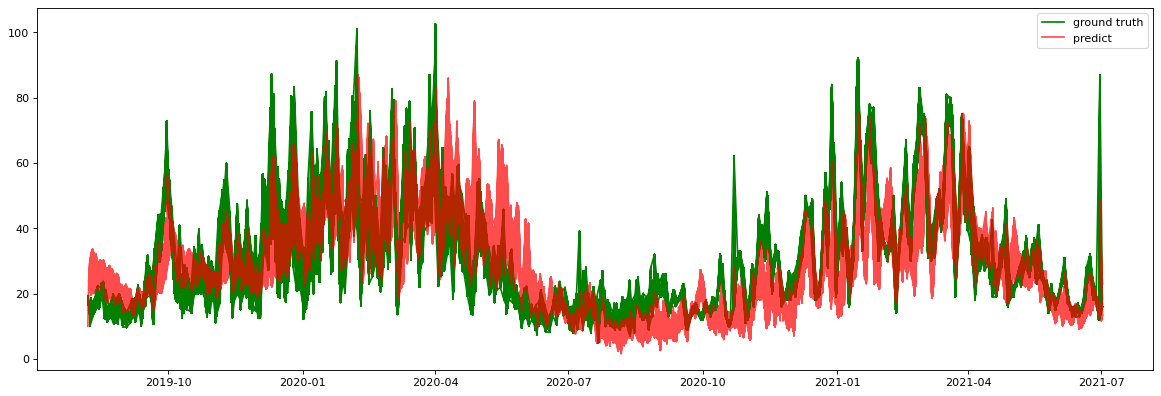

In [145]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [18]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_KKC.csv')